# 1. Importar las librerias y leer el archivo de houses_sold

In [132]:
#importar las librerias
import pandas as pd
import time
import numpy as np
import matplotlib as plt
from functools import reduce
import re

In [133]:
#leer el archivo
df= pd.read_csv('Dataset_houses_sold.csv')
#revisar su forma
df.shape

(11118, 23)

# 2.Limpieza del dataset

### Eliminar columnas

In [134]:
#columnas para eliminar con datos que no son relevantes
columns_to_drop=['source','permalink','other_listings','open_houses','branding','matterport',
                 'products','virtual_tours','community','price_reduced_amount',"last_update_date"]

#eliminar las columas
df.drop(columns=columns_to_drop,inplace=True)

### Buscar filas duplicadas

In [135]:
#buscar en la columna description por valores que esta duplicados

#crear una lista para guardas las filas de la columna description
descriptions = []
#crear lita de id que estan repetidoas
ids=[]
for index, row in df.groupby('property_id')['description'].apply(list).reset_index().iterrows():
    id=str(row['property_id'])
    
    if len(row['description']) > 1:

        descriptions.append(row['description'])
        ids.append(id)
        if len(ids) >2:
            break


In [136]:
#los id_producto que estan con filas duplicadas
ids

#ver que filas son las duplicadas
descriptions[0]

print("las ids duplicadas son", ids)
print("las filas duplicadas son",descriptions[0])


las ids duplicadas son ['1194688570', '1209011010', '1636571027']
las filas duplicadas son ["{'year_built': 1996, 'baths_3qtr': None, 'sold_date': '2023-07-20', 'sold_price': 475000, 'baths_full': 3, 'name': None, 'baths_half': 1, 'lot_sqft': 1886, 'sqft': 1916, 'baths': 3, 'sub_type': None, 'baths_1qtr': None, 'garage': None, 'stories': 1, 'beds': 4, 'type': 'townhomes'}", "{'year_built': 1996, 'baths_3qtr': None, 'sold_date': '2023-07-20', 'sold_price': 475000, 'baths_full': 3, 'name': None, 'baths_half': 1, 'lot_sqft': 1886, 'sqft': 1916, 'baths': 3, 'sub_type': None, 'baths_1qtr': None, 'garage': None, 'stories': 1, 'beds': 4, 'type': 'townhomes'}"]


In [137]:
#ver que filas son duplicadas por id, son exactamente las mimas filas por eso hay que eliminar
df[df['property_id']== 1194688570]

,primary_photo,tags,status,list_date,description,list_price,lead_attributes,property_id,photos,flags,listing_id,location
3765,{'href': 'https://ap.rdcpix.com/1888d686507789...,NaN,sold,NaN,"{'year_built': 1996, 'baths_3qtr': None, 'sold...",NaN,{'show_contact_an_agent': True},1194688570,"[{'tags': None, 'href': 'https://ap.rdcpix.com...","{'is_new_construction': None, 'is_for_rent': N...",NaN,"{'address': {'postal_code': '80030', 'state': ..."
3817,{'href': 'https://ap.rdcpix.com/1888d686507789...,NaN,sold,NaN,"{'year_built': 1996, 'baths_3qtr': None, 'sold...",NaN,{'show_contact_an_agent': True},1194688570,"[{'tags': None, 'href': 'https://ap.rdcpix.com...","{'is_new_construction': None, 'is_for_rent': N...",NaN,"{'address': {'postal_code': '80030', 'state': ..."


In [138]:
#eliminar las columnas duplicadas
df.drop_duplicates(subset='property_id', inplace = True)
print("el tamaño del dataset es :",df.shape)

el tamaño del dataset es : (11096, 12)


### Funcion para columnas anidadas

In [139]:
#definir una funcion para sacar los datos de las columnas que contiene cadenas que representan diccionarios
def data_processor(df, columnas, columna_target):
    
    # Inicializa una lista vacía llamada 'lista_dics_datos' para almacenar los datos transformados.
    lista_dics_datos = []
    
    # Itera a través de las filas del DataFrame 'df'.
    for _, row in df.iterrows():
        
        # Extrae el 'property_id' pues es unico en el dataframe de la fila actual.
        property_id = row['property_id']
            
        # Itera a través de los elementos en la columna especificada por 'columna_target'.
        for elemento in row[columna_target]:

            if elemento is not None:
                try:
                    # Crea un nuevo diccionario 'elemento_data' que contiene la información de la fila actual.
                    elemento_data = eval(elemento).copy()
                except:
                    elemento_data = elemento.copy()
            else:
                elemento_data = {}
                
            # Agrega información adicional al diccionario 'elemento_data'.
            elemento_data['property_id'] = property_id       
                       
            # Agrega el diccionario 'review_data' a la lista 'listadatos'.
            lista_dics_datos.append(elemento_data)

    # Crea un nuevo DataFrame 'df_limpio' a partir de la lista 'lista_dics_datos'
    # utilizando las columnas especificadas en 'columnas'.
    df_limpio = pd.DataFrame(lista_dics_datos, columns=columnas)
    
    # Devuelve el nuevo DataFrame 'df_limpio'.
    return df_limpio

In [140]:
#separar la columna description para poder transformarla
df1 = df.groupby('property_id')['description'].apply(list).reset_index()

#definir una lista de columnas
columns = ['property_id']

#añadir las columnas que estan dentro de description a la base de datos como columnas
columns +=[x for x in eval(df1['description'][0][0]).keys()]

#aplicar la funcion de desanidar 
df_temporal = data_processor(df1,columns,'description')

df_final = pd.merge(df_temporal,df, on='property_id')
df_final.head()


,property_id,year_built,baths_3qtr,sold_date,sold_price,baths_full,name,baths_half,lot_sqft,sqft,...,tags,status,list_date,description,list_price,lead_attributes,photos,flags,listing_id,location
0,1000385902,1914.0,NaN,2023-09-20,1640000.0,1.0,None,NaN,3480.0,1149.0,...,"['central_air', 'community_outdoor_space', 'de...",sold,2023-08-23T18:06:49Z,"{'year_built': 1914, 'baths_3qtr': None, 'sold...",1125000.0,{'show_contact_an_agent': True},NaN,"{'is_new_construction': None, 'is_for_rent': N...",2.958976e+09,"{'address': {'postal_code': '94703', 'state': ..."
1,1000796714,1942.0,NaN,2023-09-18,730000.0,2.0,None,NaN,5000.0,1084.0,...,"['community_outdoor_space', 'dishwasher', 'fir...",sold,2023-08-24T01:28:05Z,"{'year_built': 1942, 'baths_3qtr': None, 'sold...",599000.0,{'show_contact_an_agent': True},"[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...",2.958991e+09,"{'address': {'postal_code': '94804', 'state': ..."
2,1001913806,1919.0,NaN,2023-09-25,1100000.0,1.0,None,NaN,2898.0,920.0,...,"['corner_lot', 'dining_room', 'dishwasher', 'f...",sold,2023-08-18T06:35:06Z,"{'year_built': 1919, 'baths_3qtr': None, 'sold...",849000.0,{'show_contact_an_agent': True},"[{'tags': [{'label': 'house_view', 'probabilit...","{'is_new_construction': None, 'is_for_rent': N...",2.958827e+09,"{'address': {'postal_code': '94703', 'state': ..."
3,1001994147,1999.0,1.0,2023-09-28,494000.0,2.0,None,NaN,9583.0,2181.0,...,"['central_air', 'central_heat', 'community_out...",sold,2023-08-18T18:36:09Z,"{'year_built': 1999, 'baths_3qtr': 1, 'sold_da...",493999.0,{'show_contact_an_agent': True},"[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...",2.958845e+09,"{'address': {'postal_code': '93314', 'state': ..."
4,1002195150,1977.0,NaN,2023-09-15,415000.0,2.0,None,NaN,3400.0,1154.0,...,"['central_air', 'dishwasher', 'forced_air', 'l...",sold,2023-08-18T03:01:06Z,"{'year_built': 1977, 'baths_3qtr': None, 'sold...",400000.0,{'show_contact_an_agent': True},"[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...",2.958824e+09,"{'address': {'postal_code': '94509', 'state': ..."


### limpiar columnas

In [141]:
df_final.columns

Index(['property_id', 'year_built', 'baths_3qtr', 'sold_date', 'sold_price',
       'baths_full', 'name', 'baths_half', 'lot_sqft', 'sqft', 'baths',
       'sub_type', 'baths_1qtr', 'garage', 'stories', 'beds', 'type',
       'primary_photo', 'tags', 'status', 'list_date', 'description',
       'list_price', 'lead_attributes', 'photos', 'flags', 'listing_id',
       'location'],
      dtype='object')

In [142]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11096 entries, 0 to 11095
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_id      11096 non-null  int64  
 1   year_built       10447 non-null  float64
 2   baths_3qtr       556 non-null    float64
 3   sold_date        11096 non-null  object 
 4   sold_price       9062 non-null   float64
 5   baths_full       10110 non-null  float64
 6   name             0 non-null      object 
 7   baths_half       3094 non-null   float64
 8   lot_sqft         9835 non-null   float64
 9   sqft             10160 non-null  float64
 10  baths            10981 non-null  float64
 11  sub_type         1787 non-null   object 
 12  baths_1qtr       2 non-null      float64
 13  garage           6516 non-null   float64
 14  stories          9005 non-null   float64
 15  beds             10080 non-null  float64
 16  type             11085 non-null  object 
 17  primary_phot

In [143]:
#eliminar las columnas que no sirven para nuestro analisis
dropeable_columns = ['name', 'description','lead_attributes', "baths_1qtr"]
df_final.drop(columns=dropeable_columns, inplace = True)

In [144]:
#funcion para convretir las fechas a datetime
def convert_date(text):
    try:
        return pd.to_datetime(text, errors='raise')
    except ValueError:
        return np.nan

In [145]:
#aplicar la funciona a la columna sold_date
df_final['sold_date']=df_final['sold_date'].apply(convert_date)

#imprimir las columnas que son unicas
print(len(df_final['sold_date'].unique()))

127


In [146]:
#eliminar las columnas que ya no se usaran 
columns_to_drop = ['sold_date', 'sold_price','sub_type']
df_final.drop(columns=columns_to_drop, inplace= True)

In [147]:
#Quitar las letras de la fecha en list_date
df_final['list_date']=(df_final['list_date'].astype(str).str.split('T')).str[0]

#convertir list_date eb datetime
df_final['list_date'] = df_final['list_date'].apply(convert_date)

### Desanidar columnas

In [148]:
#mostar las columnas que son str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( column , df_final[column][2]+'\n')

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/104c0580f6ce07730bc6037f4d7f1db1l-m2506728521s-w1024_h768.jpg'}

tags ['corner_lot', 'dining_room', 'dishwasher', 'fireplace', 'hardwood_floors', 'laundry_room', 'recreation_facilities', 'two_or_more_stories', 'garage_1_or_more', 'updated_kitchen']

status sold

photos [{'tags': [{'label': 'house_view', 'probability': 0.98092675209045}, {'label': 'porch', 'probability': 0.90733337402344}, {'label': 'house_view', 'probability': 0.98271942138672}, {'label': 'house_view', 'probability': 0.972252368927}], 'href': 'https://ap.rdcpix.com/104c0580f6ce07730bc6037f4d7f1db1l-m2506728521s-w1024_h768.jpg'}, {'tags': [{'label': 'unknown', 'probability': 0.92532294988632}, {'label': 'house_view', 'probability': 0.98876148462296}, {'label': 'house_view', 'probability': 0.90286254882812}, {'label': 'house_view', 'probability': 0.99886333942413}], 'href': 'https://ap.rdcpix.com/104c0580f6ce07730bc6037f4d7f1db1l-m2373665635s-w1024_h768.jp

In [149]:
#ver las columnas que tienen diccionarios por dentro
df_final[['primary_photo','tags','photos','flags','location']].head()

,primary_photo,tags,photos,flags,location
0,NaN,"['central_air', 'community_outdoor_space', 'de...",NaN,"{'is_new_construction': None, 'is_for_rent': N...","{'address': {'postal_code': '94703', 'state': ..."
1,{'href': 'https://ap.rdcpix.com/64aed9a18d3926...,"['community_outdoor_space', 'dishwasher', 'fir...","[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...","{'address': {'postal_code': '94804', 'state': ..."
2,{'href': 'https://ap.rdcpix.com/104c0580f6ce07...,"['corner_lot', 'dining_room', 'dishwasher', 'f...","[{'tags': [{'label': 'house_view', 'probabilit...","{'is_new_construction': None, 'is_for_rent': N...","{'address': {'postal_code': '94703', 'state': ..."
3,{'href': 'https://ap.rdcpix.com/a493122ec95450...,"['central_air', 'central_heat', 'community_out...","[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...","{'address': {'postal_code': '93314', 'state': ..."
4,{'href': 'https://ap.rdcpix.com/0adfbdd06207a0...,"['central_air', 'dishwasher', 'forced_air', 'l...","[{'tags': [{'label': 'garage', 'probability': ...","{'is_new_construction': None, 'is_for_rent': N...","{'address': {'postal_code': '94509', 'state': ..."


In [150]:
#funcion completa para desanidar las columnas con diccionarios
def unraveler(df, target_columns:list):
    #crear una lista vacia para almacenar los datasets
    dfs_temporales =[]
    
    #iterar sobre las columnas de target_columns
    for column in target_columns:
        
        #crear un dataset con agrupado por property id pero de acuerdo a cada columna de la lista de columnas
        df_grouped = df.groupby('property_id')[column].apply(list).reset_index()
        
        #crear una lista de nombres de columnas
        columns = ['property_id']
        
        #aumentar en cada lista los valores que estan dentro de los diccionarios anidados
        try:
            columns +=[x for x in eval(df_grouped[column][0][0]).keys()]
        except:
            columns +=[x for x in (df_grouped[column][0][0]).keys()]
        
        #aplicar la funcion para desanidar
        df_temporal = data_processor(df_grouped,columns,column)
        dfs_temporales.append(df_temporal)
    
    # combinar los dataframes en uno nuevo
    resultado = reduce(lambda left, right: pd.merge(left, right, on='property_id'), dfs_temporales)
    
    #combinar los dataframe por la columna property_id
    resultado = pd.merge(resultado,df, on='property_id')
    return resultado
    

In [151]:
#columnas a convertir
columns = ['flags','location']
#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

### realizar otra limpieza

In [152]:
df_final.columns

Index(['property_id', 'is_new_construction', 'is_for_rent', 'is_subdivision',
       'is_contingent', 'is_price_reduced', 'is_pending', 'is_foreclosure',
       'is_plan', 'is_coming_soon', 'is_new_listing', 'address',
       'street_view_url', 'county', 'year_built', 'baths_3qtr', 'baths_full',
       'baths_half', 'lot_sqft', 'sqft', 'baths', 'garage', 'stories', 'beds',
       'type', 'primary_photo', 'tags', 'status', 'list_date', 'list_price',
       'photos', 'flags', 'listing_id', 'location'],
      dtype='object')

In [153]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11096 entries, 0 to 11095
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   property_id          11096 non-null  int64         
 1   is_new_construction  0 non-null      object        
 2   is_for_rent          0 non-null      object        
 3   is_subdivision       0 non-null      object        
 4   is_contingent        0 non-null      object        
 5   is_price_reduced     2164 non-null   object        
 6   is_pending           0 non-null      object        
 7   is_foreclosure       38 non-null     object        
 8   is_plan              0 non-null      object        
 9   is_coming_soon       0 non-null      object        
 10  is_new_listing       9261 non-null   object        
 11  address              11096 non-null  object        
 12  street_view_url      11096 non-null  object        
 13  county               11094 non-

In [154]:
#eliminar columnas nuevas que salieron de los diccionarios que se desanidaron
df_final.drop(columns=['is_new_listing','is_pending','flags','location'], inplace = True)

### Limpiar columnas tags

In [155]:
#ver que columnas son de tipo str
for column in df_final.columns:
    if type(df_final[column][2]) is str:
        print( f'{column}' , df_final[column][2]+'\n')

street_view_url https://maps.googleapis.com/maps/api/streetview?channel=rdc-streetview&client=gme-movesalesinc&location=1602%20Jaynes%20St%2C%20Berkeley%2C%20CA%2094703&size=640x480&source=outdoor&signature=5aAjaVi0BOebL0dIJ05XpNrJAr8=

type single_family

primary_photo {'href': 'https://ap.rdcpix.com/104c0580f6ce07730bc6037f4d7f1db1l-m2506728521s-w1024_h768.jpg'}

tags ['corner_lot', 'dining_room', 'dishwasher', 'fireplace', 'hardwood_floors', 'laundry_room', 'recreation_facilities', 'two_or_more_stories', 'garage_1_or_more', 'updated_kitchen']

status sold

photos [{'tags': [{'label': 'house_view', 'probability': 0.98092675209045}, {'label': 'porch', 'probability': 0.90733337402344}, {'label': 'house_view', 'probability': 0.98271942138672}, {'label': 'house_view', 'probability': 0.972252368927}], 'href': 'https://ap.rdcpix.com/104c0580f6ce07730bc6037f4d7f1db1l-m2506728521s-w1024_h768.jpg'}, {'tags': [{'label': 'unknown', 'probability': 0.92532294988632}, {'label': 'house_view', 'prob

In [156]:
##funcion para evaluar los nan en la columna tags
def safe_eval(expression):
    try:
        result = eval(expression)
        return result
    except Exception as e:

        if expression is np.nan:
            return expression
        else:
            
            print(f"Error en la evaluación: {e}, and was given {expression}")
            return expression


In [157]:
#se aplica la funcion a la columna tags
df_final['tags'] = df_final['tags'].apply(safe_eval)

In [158]:
#poner en lista cada una de las filas de la columna tags
def get_tags(list):
    
    my_list = []
    try:
        for tag in list:
            my_list.append(tag)
        return my_list 
    except:
        return my_list

In [159]:
#Aplicar la funciona a cada fila de la columna tags
tags = []
#recorre cada fila del datafram para sacar los tags
for index, row in df_final.iterrows():
    
    tag=get_tags(row['tags'])

    tags+=tag

In [160]:
#imprimir los resultados
print("el total de tags es:",len(tags))
print("los tags unicos son:",len(set(tags)))

el total de tags es: 116295
los tags unicos son: 165


### Definir los tags mas vendidos

In [161]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#se va a hacer un wordcloud para saber cuales son los tags mas usados
# Tu lista de palabras
lista_de_palabras = tags
# Convierte la lista en una cadena de texto
texto = " ".join(lista_de_palabras)


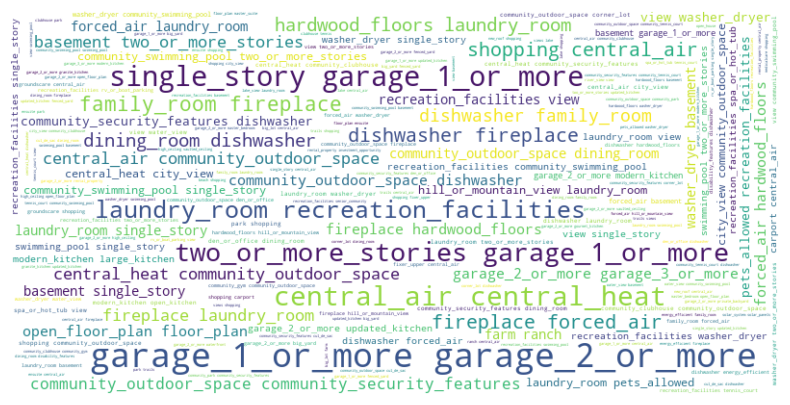

In [162]:
# Crea un objeto WordCloud
nube_de_palabras = WordCloud(width=800, height=400, background_color='white').generate(texto)

# Muestra la nube de palabras utilizando Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(nube_de_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()


In [163]:
#para eliminar las tags que son las mas frecuentes 
Start_tags=0
current_tags=1
while Start_tags != current_tags:
    Start_tags=len(tags)
    for tag in tags:
        #eliminar las palabras garage y story pues ya son parte del dataframe
        if 'garage' in tag or 'story' in tag or 'stories' in tag:
            tags.remove(tag)
    current_tags=len(tags)

In [164]:
#definir los tags unicos que hay en tags
tags_unicos ={}
#recorrer los tags para sacar un diccionario con los nombres y cantidad de tags
for tag in tags:
    if tag not in tags_unicos.keys():
        tags_unicos[tag]=tags.count(tag)
    else:
        tags.remove(tag)

#poner el resultado del diccionario en un dataframe
top_50_tags = pd.DataFrame(tags_unicos.values(),tags_unicos.keys()).sort_values(by=0,ascending=False).head(50).rename(columns={0:'count'})
top_50_tags.head(3)

,count
central_air,5720
laundry_room,5286
community_outdoor_space,4653


### Desanidar las columnas que faltan

In [166]:
#columnas a convertir
columns = ['address',"county"]

#aplicar la funcion para desanidar
df_final = unraveler(df_final, columns)

#aplicar a la columna que se desanido a partir de adress
df_final = unraveler(df_final,['coordinate'])

#eliminar las columnas que ya se trabajaron
df_final.drop(columns=['coordinate','county','address'], inplace=True)

In [167]:
df_final.columns

Index(['property_id', 'lon', 'lat', 'postal_code', 'state', 'city',
       'state_code', 'line', 'fips_code', 'name', 'is_new_construction',
       'is_for_rent', 'is_subdivision', 'is_contingent', 'is_price_reduced',
       'is_foreclosure', 'is_plan', 'is_coming_soon', 'street_view_url',
       'year_built', 'baths_3qtr', 'baths_full', 'baths_half', 'lot_sqft',
       'sqft', 'baths', 'garage', 'stories', 'beds', 'type', 'primary_photo',
       'tags', 'status', 'list_date', 'list_price', 'photos', 'listing_id'],
      dtype='object')

In [168]:
#aplicar la funcion safe eval para preparar la columna photos para desanidarla
df_final['photos'] = df_final['photos'].apply(safe_eval)

#funcion para obtener de la columna photos el segundo link de la foto, le primero ya se tiene en la columna photo
def get_second_photo(list):
    try:
        #toma el segundo link de foto
        list=list[1]
        #toma el link sin la palabra href previo al url
        list=list['href']
        return list
        #sino encuentra un segundo link, toma el primero
    except:
        try:
            list=list[0]
            list = list['href']
            return list 
        except:
            
            return list

#aplicar la funcion para sacar la segunda foto    
df_final['photos'] = df_final['photos'].apply(get_second_photo)

In [169]:
df_final

,property_id,lon,lat,postal_code,state,city,state_code,line,fips_code,name,...,stories,beds,type,primary_photo,tags,status,list_date,list_price,photos,listing_id
0,1000385902,-122.278787,37.877566,94703,California,Berkeley,CA,1532 McGee Ave,06001,Alameda,...,1.0,2.0,single_family,NaN,"[central_air, community_outdoor_space, den_or_...",sold,2023-08-23,1125000.0,NaN,2.958976e+09
1,1000796714,-122.336493,37.942205,94804,California,Richmond,CA,3211 Clinton Ave,06013,Contra Costa,...,1.0,2.0,single_family,{'href': 'https://ap.rdcpix.com/64aed9a18d3926...,"[community_outdoor_space, dishwasher, fireplac...",sold,2023-08-24,599000.0,https://ap.rdcpix.com/64aed9a18d39263e131c5237...,2.958991e+09
2,1001913806,-122.280329,37.877482,94703,California,Berkeley,CA,1602 Jaynes St,06001,Alameda,...,2.0,2.0,single_family,{'href': 'https://ap.rdcpix.com/104c0580f6ce07...,"[corner_lot, dining_room, dishwasher, fireplac...",sold,2023-08-18,849000.0,https://ap.rdcpix.com/104c0580f6ce07730bc6037f...,2.958827e+09
3,1001994147,-119.161436,35.358035,93314,California,Bakersfield,CA,408 Calle Manzana,06029,Kern,...,1.0,3.0,single_family,{'href': 'https://ap.rdcpix.com/a493122ec95450...,"[central_air, central_heat, community_outdoor_...",sold,2023-08-18,493999.0,https://ap.rdcpix.com/a493122ec9545059f24c7c16...,2.958845e+09
4,1002195150,-121.825823,38.002719,94509,California,Antioch,CA,2313 Banyan Way,06013,Contra Costa,...,1.0,3.0,single_family,{'href': 'https://ap.rdcpix.com/0adfbdd06207a0...,"[central_air, dishwasher, forced_air, laundry_...",sold,2023-08-18,400000.0,https://ap.rdcpix.com/0adfbdd06207a09648b0ff96...,2.958824e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,9997392724,-80.149051,25.972484,33180,Florida,Miami,FL,2651 NE 212th Ter Apt 105,12086,Miami-Dade,...,NaN,2.0,condos,{'href': 'https://ap.rdcpix.com/9752a707760b19...,"[carport, central_air, central_heat, community...",sold,2023-06-28,345000.0,https://ap.rdcpix.com/9752a707760b19cd5006c9df...,2.957141e+09
11092,9997985885,-92.302679,38.917119,65201,Missouri,Columbia,MO,3005 Chinaberry Dr # A,29019,Boone,...,NaN,NaN,other,NaN,NaN,sold,NaT,NaN,NaN,NaN
11093,9998773770,-85.453590,38.255417,40245,Kentucky,Louisville,KY,17120 Meander Way,21111,Jefferson,...,NaN,NaN,land,{'href': 'https://nh.rdcpix.com/e2f5a73bd772af...,NaN,sold,NaT,NaN,https://nh.rdcpix.com/e2f5a73bd772af8863e86dac...,NaN
11094,9998824963,-87.912712,43.044838,53202,Wisconsin,Milwaukee,WI,1137 N Edison St,55079,Milwaukee,...,2.0,2.0,condos,{'href': 'https://ap.rdcpix.com/1fee1a1bd7a333...,"[dishwasher, river_view, view, washer_dryer, w...",sold,2023-06-20,700000.0,https://ap.rdcpix.com/1fee1a1bd7a333a5828450a5...,2.956881e+09


In [170]:
df_final.to_csv('Houses_sold_procesed.csv',index = False)

In [ ]:
columnas_compro=['property_id', 'lon', 'lat', 'postal_code', 'state', 'city',
       'state_code', 'line', 'fips_code', 'name', 'is_new_construction',
       'is_subdivision', 'is_plan', 'is_price_reduced', 'is_foreclosure',
       'is_coming_soon', 'is_contingent', 'street_view_url', 'sqft',
       'baths_consolidated', 'lot_sqft', 'year_built', 'garage', 'stories',
       'beds', 'type', 'primary_photo', 'tags', 'list_date', 'photos',
       'list_price', 'listing_id', 'primary', 'status']